In [1]:
import os
import time
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from collections import Counter

# Define the folder containing the images
image_folder = '/Users/louieburns/Library/CloudStorage/OneDrive-UniversityofLeeds/Year 3/AI and Machine Learning/Term 1/Coursework 1/Actual Coursework/dataoriginal/images'

# Paths to the text files
train_label_file = '/Users/louieburns/Library/CloudStorage/OneDrive-UniversityofLeeds/Year 3/AI and Machine Learning/Term 1/Coursework 1/Actual Coursework/dataoriginal/images_variant_train.txt'
test_label_file = '/Users/louieburns/Library/CloudStorage/OneDrive-UniversityofLeeds/Year 3/AI and Machine Learning/Term 1/Coursework 1/Actual Coursework/dataoriginal/images_variant_test.txt'
val_label_file = '/Users/louieburns/Library/CloudStorage/OneDrive-UniversityofLeeds/Year 3/AI and Machine Learning/Term 1/Coursework 1/Actual Coursework/dataoriginal/images_variant_trainval.txt'

# Define label mapping with updated aircraft models
label_mapping = {
    "707-320": 0,
    "727-200": 1,
    "737-200": 2,
    "737-300": 3,
    "737-400": 4,
    "737-500": 5,
    "737-600": 6,
    "737-700": 7,
    "737-800": 8,
    "737-900": 9,
    "747-100": 10,
    "747-200": 11,
    "747-300": 12,
    "747-400": 13,
    "757-200": 14,
    "757-300": 15,
    "767-200": 16,
    "767-300": 17,
    "767-400": 18,
    "777-200": 19,
    "777-300": 20,
    "A300B4": 21,
    "A310": 22,
    "A318": 23,
    "A319": 24,
    "A320": 25,
    "A321": 26,
    "A330-200": 27,
    "A330-300": 28,
    "A340-200": 29,
    "A340-300": 30,
    "A340-500": 31,
    "A340-600": 32,
    "A380": 33,
    "ATR-42": 34,
    "ATR-72": 35,
    "An-12": 36,
    "BAE 146-200": 37,
    "BAE 146-300": 38,
    "BAE-125": 39,
    "Beechcraft 1900": 40,
    "Boeing 717": 41,
    "C-130": 42,
    "C-47": 43,
    "CRJ-200": 44,
    "CRJ-700": 45,
    "CRJ-900": 46,
    "Cessna 172": 47,
    "Cessna 208": 48,
    "Cessna 525": 49,
    "Cessna 560": 50,
    "Challenger 600": 51,
    "DC-10": 52,
    "DC-3": 53,
    "DC-6": 54,
    "DC-8": 55,
    "DC-9-30": 56,
    "DH-82": 57,
    "DHC-1": 58,
    "DHC-6": 59,
    "DHC-8-100": 60,
    "DHC-8-300": 61,
    "DR-400": 62,
    "Dornier 328": 63,
    "E-170": 64,
    "E-190": 65,
    "E-195": 66,
    "EMB-120": 67,
    "ERJ 135": 68,
    "ERJ 145": 69,
    "Embraer Legacy 600": 70,
    "Eurofighter Typhoon": 71,
    "F-16A/B": 72,
    "F/A-18": 73,
    "Falcon 2000": 74,
    "Falcon 900": 75,
    "Fokker 100": 76,
    "Fokker 50": 77,
    "Fokker 70": 78,
    "Global Express": 79,
    "Gulfstream IV": 80,
    "Gulfstream V": 81,
    "Hawk T1": 82,
    "Il-76": 83,
    "L-1011": 84,
    "MD-11": 85,
    "MD-80": 86,
    "MD-87": 87,
    "MD-90": 88,
    "Metroliner": 89,
    "Model B200": 90,
    "PA-28": 91,
    "SR-20": 92,
    "Saab 2000": 93,
    "Saab 340": 94,
    "Spitfire": 95,
    "Tornado": 96,
    "Tu-134": 97,
    "Tu-154": 98,
    "Yak-42": 99
}


# Define transformations for image processing
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to 64x64
    transforms.ToTensor(),          # Convert to tensor
])

def filter_data(label_file, selected_labels):
    image_data = []
    labels = []

    with open(label_file, "r") as f:
        for line in f:
            parts = line.strip().split(maxsplit=1)
            if len(parts) != 2:
                continue  # Skip malformed lines
            filename, label = parts
            if label in selected_labels:
                image_path = os.path.join(image_folder, filename + ".jpg")
                try:
                    if os.path.exists(image_path):
                        image = Image.open(image_path).convert("RGB")
                        image_tensor = transform(image)
                        image_data.append(image_tensor)
                        labels.append(selected_labels[label])
                except Exception as e:
                    print(f"Error processing {image_path}: {e}")

    # Convert lists to PyTorch tensors
    image_tensor = torch.stack(image_data)
    label_tensor = torch.tensor(labels, dtype=torch.long)

    return image_tensor, label_tensor, labels

# Process training, validation, and test data for selected labels
train_image_tensor, train_label_tensor, train_labels = filter_data(train_label_file, label_mapping)
val_image_tensor, val_label_tensor, val_labels = filter_data(val_label_file, label_mapping)
test_image_tensor, test_label_tensor, test_labels = filter_data(test_label_file, label_mapping)

# Print dataset sizes
print(f"Number of training images: {len(train_image_tensor)}")
print(f"Number of validation images: {len(val_image_tensor)}")
print(f"Number of test images: {len(test_image_tensor)}")

# Print counts for each class in training, validation, and test datasets
train_counts = Counter(train_labels)
val_counts = Counter(val_labels)
test_counts = Counter(test_labels)

print("Training dataset class distribution:")
for label, count in train_counts.items():
    print(f"{list(label_mapping.keys())[list(label_mapping.values()).index(label)]}: {count}")

print("Validation dataset class distribution:")
for label, count in val_counts.items():
    print(f"{list(label_mapping.keys())[list(label_mapping.values()).index(label)]}: {count}")

print("Test dataset class distribution:")
for label, count in test_counts.items():
    print(f"{list(label_mapping.keys())[list(label_mapping.values()).index(label)]}: {count}")

# Create TensorDatasets
train_dataset = TensorDataset(train_image_tensor, train_label_tensor)
val_dataset = TensorDataset(val_image_tensor, val_label_tensor)
test_dataset = TensorDataset(test_image_tensor, test_label_tensor)

# Example usage of DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

print("DataLoaders for selected labels created successfully.")

# Define a simplified CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 32 * 32, len(label_mapping))
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        return x

# Instantiate the simplified model
model = SimpleCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
num_epochs = 15
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
f1_scores = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = correct_train / total_train

    # Validation phase
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    test_accuracy = correct_test / total_test
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    # Store metrics
    train_losses.append(running_loss / len(train_loader))
    test_losses.append(test_loss / len(test_loader))
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    f1_scores.append(f1)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.4f}, Test Loss: {test_loss/len(test_loader):.4f}, Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}, F1 Score: {f1:.4f}")

print("Training complete.")

Number of training images: 3334
Number of validation images: 6667
Number of test images: 3333
Training dataset class distribution:
707-320: 34
727-200: 33
737-200: 33
737-300: 34
737-400: 33
737-500: 33
737-600: 34
737-700: 33
737-800: 33
737-900: 34
747-100: 33
747-200: 33
747-300: 34
747-400: 33
757-200: 33
757-300: 34
767-200: 33
767-300: 33
767-400: 34
777-200: 33
777-300: 33
A300B4: 34
A310: 33
A318: 33
A319: 34
A320: 33
A321: 33
A330-200: 34
A330-300: 33
A340-200: 33
A340-300: 34
A340-500: 33
A340-600: 33
A380: 34
ATR-42: 33
ATR-72: 33
An-12: 34
BAE 146-200: 33
BAE 146-300: 33
BAE-125: 34
Beechcraft 1900: 33
Boeing 717: 33
C-130: 34
C-47: 33
CRJ-200: 33
CRJ-700: 34
CRJ-900: 33
Cessna 172: 33
Cessna 208: 34
Cessna 525: 33
Cessna 560: 33
Challenger 600: 34
DC-10: 33
DC-3: 33
DC-6: 34
DC-8: 33
DC-9-30: 33
DH-82: 34
DHC-1: 33
DHC-6: 33
DHC-8-100: 34
DHC-8-300: 33
DR-400: 33
Dornier 328: 34
E-170: 33
E-190: 33
E-195: 34
EMB-120: 33
ERJ 135: 33
ERJ 145: 34
Embraer Legacy 600: 33
Eurofi

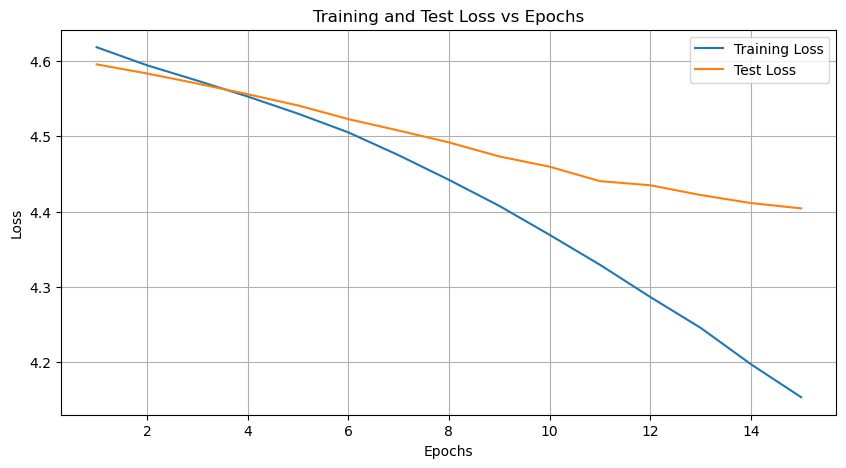

In [3]:
# Plotting results
epochs = range(1, num_epochs + 1)

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

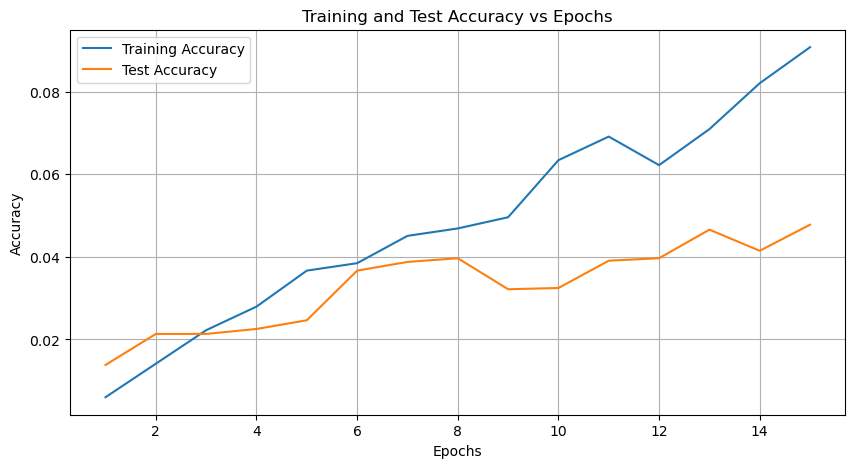

In [5]:
# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()  

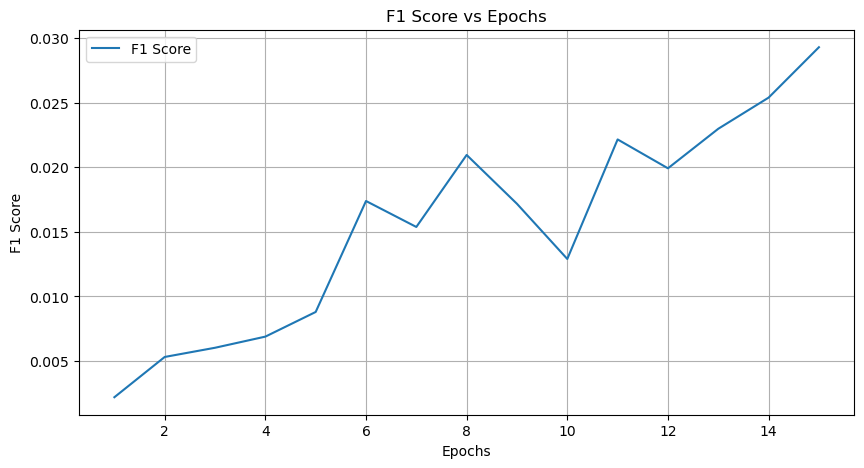

[0.0022098124567836875, 0.005323640812397169, 0.006034988103121388, 0.006896458154904226, 0.008802807673586365, 0.01738474525766714, 0.015377399087891454, 0.020946060740026765, 0.01716822255990981, 0.012902535426813671, 0.022147021917342975, 0.019914269314424932, 0.022971434333713292, 0.025380722675646467, 0.02927844898665681]


In [7]:
# Plot F1 Score
plt.figure(figsize=(10, 5))
plt.plot(epochs, f1_scores, label='F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Epochs')
plt.legend()
plt.grid(True)
plt.show()



print(f1_scores)